# algorithm chain & pipeline

* 입력 데이터의 표현 형태에 매우 민감한 머신러닝 algorithm이 많음  
* 직접 데이터의 스케일을 조정하고 특성을 연결하거나, 비지도 학습으로 특성을 만들기도 함  
* 따라서 대부분의 머신러닝은 하나의 algorithm으로 이뤄져 있지 않고, 여러 단계의 처리 과정과 머신러닝 모델이 연결되어 있음  

## Set up

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore")

## SVM training

In [2]:
# 다음은 데이터를 분할하고 최솟값, 최댓값을 찾아 데이터의 스케일을 바꾸고 SVM훈련시키는 코드
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
print('{}'.format(cancer.keys()))

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [3]:
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    stratify=cancer.target, random_state=0)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# modeling
svc = SVC(C=1, kernel='rbf', gamma='auto', degree=3)
svc.fit(x_train_scaled, y_train)

pre_train_score = svc.score(x_train_scaled, y_train)
print('{:.3f}'.format(pre_train_score))

0.955


In [4]:
pre_test_score = svc.score(x_test_scaled, y_test)
print('{:.3f}'.format(pre_test_score))
# 0.951

0.951


## GridSearchCV를 사용해서 모델 향상

In [5]:
from sklearn.model_selection import GridSearchCV
import numpy as np

values = np.array([0.001, 0.01, 0.1, 1, 10, 100])
params = {'C':values, 'gamma':values}

grid = GridSearchCV(SVC(), param_grid=params, cv=5)
grid.fit(x_train_scaled, y_train)
print('optimal parameter {}'.format(grid.best_params_))
print('best CV score {:.3f}'.format(grid.best_score_))
print('best test score {:.3f}'.format(grid.score(x_test_scaled, y_test)))

optimal parameter {'C': 1.0, 'gamma': 1.0}
best CV score 0.981
best test score 0.944


/home/ururu/.conda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


> 여기서 스케일을 조정한 데이터를 사용해서 SVC의 parameter에 대해 grid search를 수행  

모델 수행절차
1. 데이터의 최솟값과 최댓값을 계산할 때 학습을 위해 train set에 있는 모든 데이터를 사용  
2. 후에 스케일이 조정된 train data에서 교차 검증을 사용해 grid search를 수행  
* 교차 검증의 각 분할에서 원본 훈련 세트 데이터의 어떤 부분은 훈련 폴드가 되고 어떤 부분은 검증 폴드가 됨 
* 검증 폴드는 훈련 폴드로 학습된 모델이 새로운 데이터에 적용될 때의 성능을 측정하는 데 사용  
* 그러나 데이터 스케일을 조정할 때 검증 폴드에 있는 정보까지 이미 사용했음  
    * 다시 말하면 교차 검증의 반복마다 선택된 검증 폴드는 전체 훈련 세트의 일부이며, 데이터의 스케일을 조정하기 위해 전체 훈련 세트를 이용. 
    * 하지만 이는 새로운 데이터가 모델에 나타날 때와는 완전히 다름.  
    * 새로운 데이터가 관측되면 이 데이터는 훈련 데이터의 스케일 조정에 사용되지 않은 것이라, 그 최솟값과 최댓값이 훈련 데이터와 다를 수 있음

이 과정을 **시각화**하면

In [6]:
## visualization

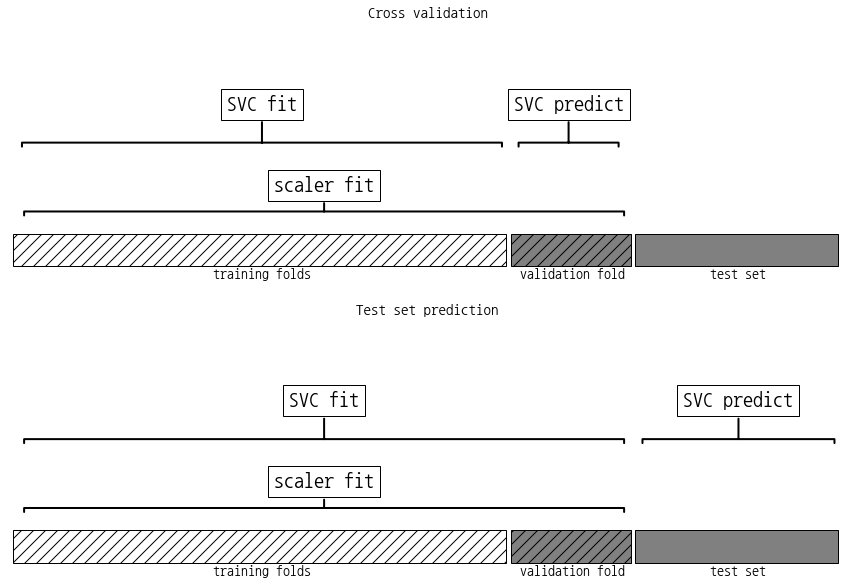

In [7]:
from mglearn.plots import plot_improper_processing
import matplotlib.pyplot as plt

plot_improper_processing()
plt.show()
# 교차 검증 반복 밖에서 전처리가 될 때 데이터 사용 형태

* 이렇기 때문에 교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때를 올바로 반영하지 못하고 있음  
* 검증 폴드 데이터의 정보가 모델 구축 과정에 이미 누설되었으므로 교차 검증에서 최적의 매개변수를 찾지 못하고 낙관적인 결과가 만들어지게 됨  

---

* 이 문제를 해결하려면 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄저야 하며 데이터셋의 정보를 이용하는 모든 처리 과정은 데이터셋의 훈련 부분에만 적용되어야 하므로 교차 검증 반복 안에 있어야 함  

**scikit-learn에서 cross_var_score 함수와 GridSearchCV로 이런 방식을 구현하려면 Pipeline을 사용**  
Pipeline은 여러 처리 단계를 하나의 scikit-learn 추정기 형태로 묶어주는 파이썬 클래스입니다. Pipeline은 fit, predict, score 메소드를 제공합니다.  
Pipeline을 사용하는 가장 일반적인 경우는 분류기 같은 지도 학습 모델과 전처리 단계를 연결할 때임  

---

MinMaxScaler로 데이터의 스케일을 조정하고 SVM 모델을 훈련시키는 workflow를 Pipeline을 사용해 표현해보면

In [8]:
from sklearn.pipeline import Pipeline

scaler_tuple = ('scaler', MinMaxScaler())
model_tuple = ('svm', SVC())

pipe = Pipeline([scaler_tuple, model_tuple])
pipe.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

* pipe.fit은 첫 번째 단계(scaler)의 fit 매소드를 호출하여 훈련데이터를 변환하고, 마지막에는 변환된 데이터에 SVM모델을 학습시킵니다. 테스트 세트로 평가하려면 pipe.score를 호출  

In [9]:
pipe_train_score = pipe.score(x_train, y_train)
pipe_test_score = pipe.score(x_test, y_test)

print('{:.3f}'.format(pipe_train_score))
print('{:.3f}'.format(pipe_test_score))

0.955
0.951
